In [1]:
# 🚀 Auto-setup: installs deps + configures CFBD access
import os
import sys
from pathlib import Path

# Find _auto_setup.py regardless of current working directory
_current = Path().resolve()
_auto_setup_path = None
for parent in [_current] + list(_current.parents):
    candidate = parent / "starter_pack" / "_auto_setup.py"
    if candidate.exists():
        _auto_setup_path = candidate
        # Add project root to sys.path (auto_setup.py will also do this)
        if str(parent) not in sys.path:
            sys.path.insert(0, str(parent))
        break

if _auto_setup_path and _auto_setup_path.exists():
    # Execute the file directly without changing directory
    with open(_auto_setup_path, 'r') as f:
        exec(f.read(), {'__file__': str(_auto_setup_path)})
else:
    # Fallback: try relative path
    try:
        with open("./_auto_setup.py", 'r') as f:
            exec(f.read(), {'__file__': './_auto_setup.py'})
    except FileNotFoundError:
        print("⚠️  Could not find _auto_setup.py. Please run from starter_pack directory.")


ModuleNotFoundError: No module named 'starter_pack'

In [2]:
# 02_build_simple_rankings.ipynb
# 📊 Building Simple Team Power Rankings

# 🛠 Requirements:
# - pandas, matplotlib, seaborn (install via `pip install pandas matplotlib seaborn`)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sys
from pathlib import Path

# Import starter pack configuration system
_config_dir = Path().resolve() / "config"
if str(_config_dir.parent) not in sys.path:
    sys.path.insert(0, str(_config_dir.parent))
from config.data_config import get_starter_pack_config

# Get configuration
config = get_starter_pack_config()
DATA_DIR = str(config.data_dir)

# Configure plots
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,8]


In [3]:
# 🔢 Load advanced season stats for a recent year
stats_path = os.path.join(DATA_DIR, "advanced_season_stats", f"{config.current_year}.csv")
stats = pd.read_csv(stats_path)

print(f"{len(stats)} records loaded")
stats.head()


136 records loaded


,season,team,conference,offense_passingPlays_explosiveness,offense_passingPlays_successRate,offense_passingPlays_totalPPA,offense_passingPlays_ppa,offense_passingPlays_rate,offense_rushingPlays_explosiveness,offense_rushingPlays_successRate,...,defense_lineYardsTotal,defense_lineYards,defense_stuffRate,defense_powerSuccess,defense_explosiveness,defense_successRate,defense_totalPPA,defense_ppa,defense_drives,defense_plays
0,2025,Air Force,Mountain West,2.068482,0.483660,87.090222,0.569217,0.222384,0.952013,0.482042,...,980,3.265667,0.143333,0.738095,1.388718,0.498333,249.809410,0.416349,103,600
1,2025,Akron,Mid-American,1.520334,0.387500,67.515966,0.168790,0.512164,0.764946,0.430137,...,1088,2.963215,0.215259,0.596154,1.332486,0.412256,127.031010,0.176923,139,718
2,2025,Alabama,SEC,1.639582,0.495979,171.552351,0.459926,0.546120,0.858739,0.396721,...,851,2.791475,0.180328,0.717391,1.263637,0.383051,41.427867,0.070217,107,590
3,2025,App State,Sun Belt,1.594993,0.384075,70.273831,0.164576,0.596369,0.787054,0.425000,...,931,2.763798,0.195846,0.720000,1.254033,0.436986,128.120832,0.175508,119,730
4,2025,Arizona,Big 12,1.520213,0.417614,72.691844,0.206511,0.523031,1.046193,0.433962,...,1004,2.902601,0.190751,0.688889,1.201469,0.374251,58.829852,0.088069,119,668


In [4]:
# 📂 Inspect available columns
stats.columns.tolist()

['season',
 'team',
 'conference',
 'offense_passingPlays_explosiveness',
 'offense_passingPlays_successRate',
 'offense_passingPlays_totalPPA',
 'offense_passingPlays_ppa',
 'offense_passingPlays_rate',
 'offense_rushingPlays_explosiveness',
 'offense_rushingPlays_successRate',
 'offense_rushingPlays_totalPPA',
 'offense_rushingPlays_ppa',
 'offense_rushingPlays_rate',
 'offense_passingDowns_explosiveness',
 'offense_passingDowns_successRate',
 'offense_passingDowns_ppa',
 'offense_passingDowns_rate',
 'offense_standardDowns_explosiveness',
 'offense_standardDowns_successRate',
 'offense_standardDowns_ppa',
 'offense_standardDowns_rate',
 'offense_havoc_db',
 'offense_havoc_frontSeven',
 'offense_havoc_total',
 'offense_fieldPosition_averagePredictedPoints',
 'offense_fieldPosition_averageStart',
 'offense_pointsPerOpportunity',
 'offense_totalOpportunies',
 'offense_openFieldYardsTotal',
 'offense_openFieldYards',
 'offense_secondLevelYardsTotal',
 'offense_secondLevelYards',
 'offen

In [5]:
# 🧼 Filter to FBS teams only and drop teams with missing data
fbs_stats = stats[stats['conference'].notnull()].copy()
fbs_stats = fbs_stats.dropna(subset=['offense_ppa', 'defense_ppa'])

print(f"{len(fbs_stats)} FBS teams with valid data")

136 FBS teams with valid data


In [6]:
# 🥇 Build simple rankings:
# We'll use offensive PPA (higher is better) and defensive PPA (lower is better)
# Normalize both so higher = better

# Normalize metrics (min-max)
fbs_stats['offense_score'] = (fbs_stats['offense_ppa'] - fbs_stats['offense_ppa'].min()) / (fbs_stats['offense_ppa'].max() - fbs_stats['offense_ppa'].min())
fbs_stats['defense_score'] = (fbs_stats['defense_ppa'].max() - fbs_stats['defense_ppa']) / (fbs_stats['defense_ppa'].max() - fbs_stats['defense_ppa'].min())

# Weighted average — you can tweak these weights
fbs_stats['rating'] = (0.5 * fbs_stats['offense_score']) + (0.5 * fbs_stats['defense_score'])

In [7]:
# 🏆 Top 25 teams by rating
top_teams = fbs_stats.sort_values('rating', ascending=False).head(25)
top_teams[['team', 'conference', 'offense_ppa', 'defense_ppa', 'rating']]

,team,conference,offense_ppa,defense_ppa,rating
86,Oregon,Big Ten,0.404126,-0.007757,0.918564
81,Ohio State,Big Ten,0.381189,-0.022658,0.907442
41,Indiana,Big Ten,0.347293,0.011317,0.835739
121,Utah,Big 12,0.340484,0.011083,0.828301
109,Texas Tech,Big 12,0.278920,-0.047222,0.816515
110,Toledo,Mid-American,0.227002,-0.090270,0.800533
120,USC,Big Ten,0.400957,0.122592,0.786350
60,Miami,ACC,0.247128,-0.023104,0.756909
129,Washington,Big Ten,0.337486,0.088173,0.748843
105,Tennessee,SEC,0.344170,0.099064,0.745620


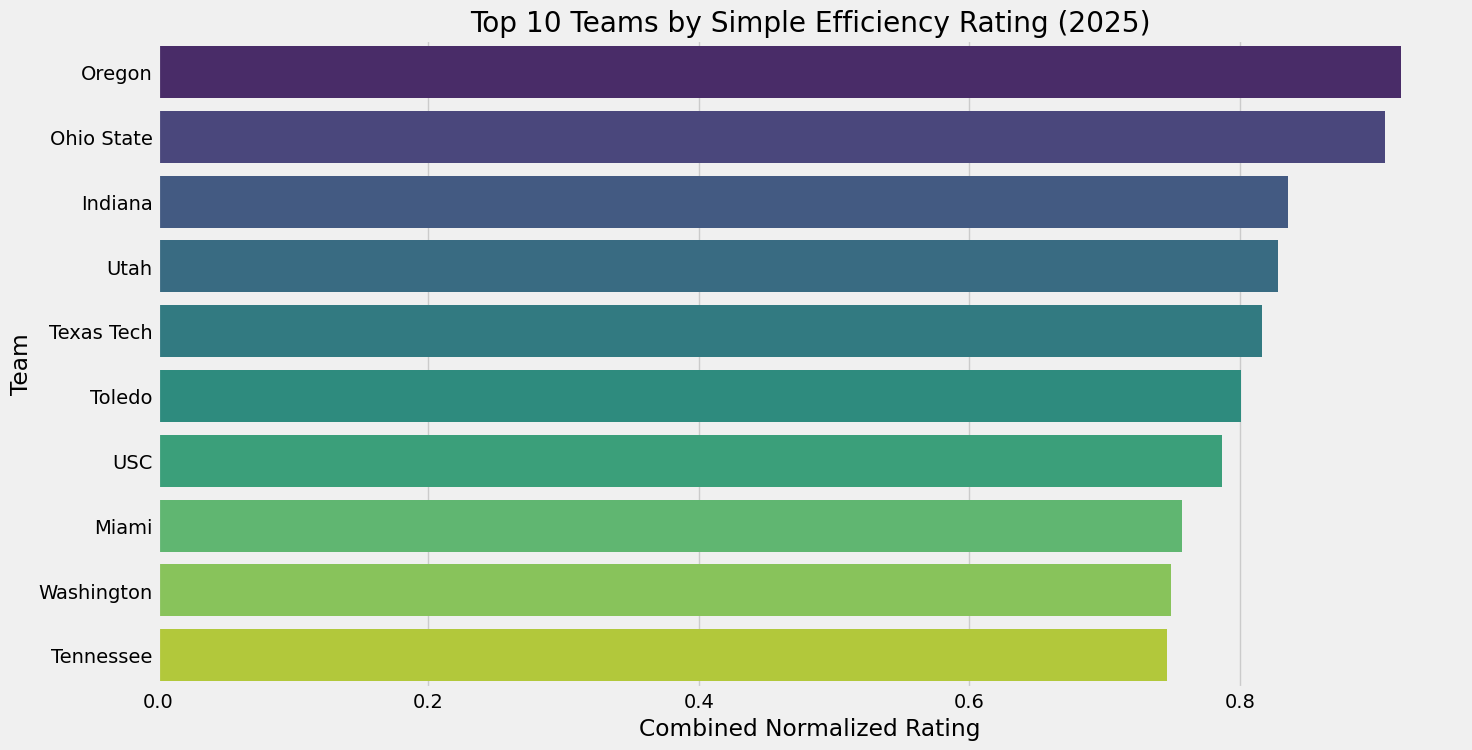

In [8]:
# 📊 Visualize top 10 teams
sns.barplot(
    data=top_teams.head(10),
    x='rating',
    y='team',
    palette='viridis',
    hue=top_teams.head(10)['team'],
    legend=False
)
plt.title(f"Top 10 Teams by Simple Efficiency Rating ({config.current_year})")
plt.xlabel("Combined Normalized Rating")
plt.ylabel("Team")
plt.show()

In [9]:
# 🥇 Build less simple rankings:
# We'll use offensive success rate (higher is better) and defensive success rate (lower is better) in addition to PPA
# Normalize all so higher = better

# Create a helper function to normalize metrics
def normalize_metric(series, invert=False):
    if invert:
        return (series.max() - series) / (series.max() - series.min())
    else:
        return (series - series.min()) / (series.max() - series.min())

# Normalize metrics (min-max)
fbs_stats['offense_ppa_score'] = normalize_metric(fbs_stats['offense_ppa'])
fbs_stats['defense_ppa_score'] = normalize_metric(fbs_stats['defense_ppa'], invert=True)
fbs_stats['offense_success_rate_score'] = normalize_metric(fbs_stats['offense_successRate'])
fbs_stats['defense_success_rate_score'] = normalize_metric(fbs_stats['defense_successRate'], invert=True)

# Weighted average — you can tweak these weights
fbs_stats['rating'] = (0.25 * fbs_stats['offense_score']) + (0.25 * fbs_stats['defense_score']) + (0.25 * fbs_stats['offense_success_rate_score']) + (0.25 * fbs_stats['defense_success_rate_score'])

# Reprint top 25 teams by new rating
# 🏆 Top 25 teams by rating
top_teams = fbs_stats.sort_values('rating', ascending=False).head(25)
top_teams[['team', 'conference', 'offense_ppa', 'defense_ppa', 'offense_successRate', 'defense_successRate', 'rating']]

,team,conference,offense_ppa,defense_ppa,offense_successRate,defense_successRate,rating
81,Ohio State,Big Ten,0.381189,-0.022658,0.561709,0.358182,0.884638
41,Indiana,Big Ten,0.347293,0.011317,0.534641,0.330565,0.852494
86,Oregon,Big Ten,0.404126,-0.007757,0.509317,0.360738,0.832029
121,Utah,Big 12,0.340484,0.011083,0.499318,0.357879,0.779701
109,Texas Tech,Big 12,0.278920,-0.047222,0.457249,0.319672,0.774071
110,Toledo,Mid-American,0.227002,-0.090270,0.450292,0.327391,0.749747
60,Miami,ACC,0.247128,-0.023104,0.484536,0.342857,0.745961
45,James Madison,Sun Belt,0.234186,0.010956,0.456067,0.298969,0.743083
129,Washington,Big Ten,0.337486,0.088173,0.513514,0.397535,0.708659
67,Missouri,SEC,0.265080,0.036060,0.479564,0.354027,0.708605


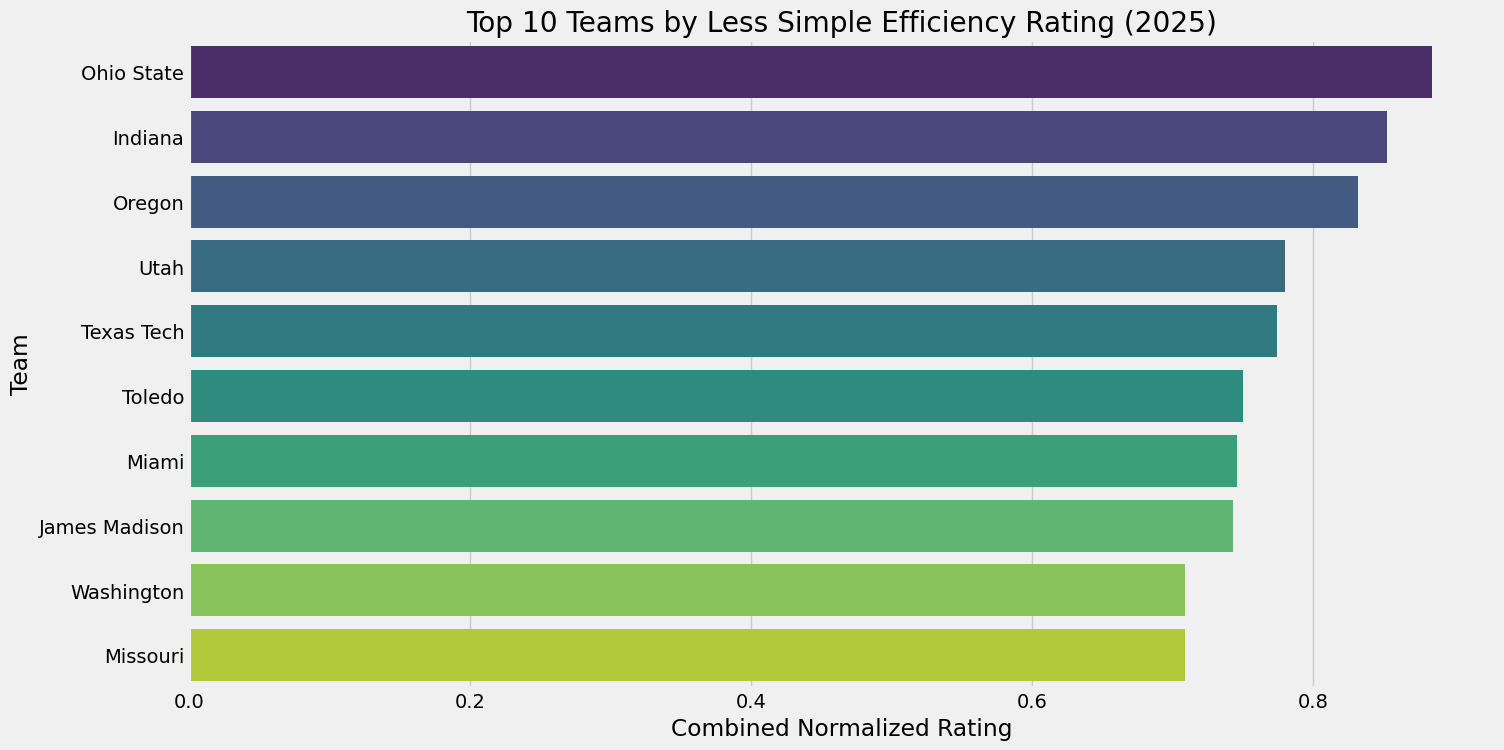

In [10]:
# 📊 Visualize new top 10 teams
sns.barplot(
    data=top_teams.head(10),
    x='rating',
    y='team',
    palette='viridis',
    hue=top_teams.head(10)['team'],
    legend=False
)
plt.title(f"Top 10 Teams by Less Simple Efficiency Rating ({config.current_year})")
plt.xlabel("Combined Normalized Rating")
plt.ylabel("Team")
plt.show()

In [11]:
# 💡 What next?
# - Add more metrics
# - Adjust the rating weights
# - Compare to final AP or CFP rankings to measure predictive power

# 🧪 You can also join this data with games.csv to track rating evolution over the season.